# 1 - Import library

---

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

from scipy.stats import pearsonr

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brasil-real-estate/Brasile-real-estate-dataset.csv


# 2 - Reading Dataset
---
The dataset consists of **7 features** and **12,833 rows**. Below are the feature details:

### Features:
- **Property_type**: Type of property (categorical: apartment, house).
- **State**: The state where the property is located (categorical: Sao Paulo, Rio Grande do Sul, etc.).
- **Region**: The region in Brazil (categorical: Southeast, South, Northeast, North).
- **Lat**: Latitude (numerical).
- **Lon**: Longitude (numerical).
- **Area_m2**: The area of the property in square meters (numl rows).
- **Price_brl**: Price of the property in BRL (numerical).


In [2]:
df = pd.read_csv('/kaggle/input/brasil-real-estate/Brasile-real-estate-dataset.csv', encoding='latin1')

df.drop(df.columns[0],axis=1, inplace = True)

display(df)

,property_type,state,region,lat,lon,area_m2,price_brl
0,apartment,Pernambuco,Northeast,-8.134204,-34.906326,72.0,414222.98
1,apartment,Pernambuco,Northeast,-8.126664,-34.903924,136.0,848408.53
2,apartment,Pernambuco,Northeast,-8.125550,-34.907601,75.0,299438.28
3,apartment,Pernambuco,Northeast,-8.120249,-34.895920,187.0,848408.53
4,apartment,Pernambuco,Northeast,-8.142666,-34.906906,80.0,464129.36
...,...,...,...,...,...,...,...
12828,house,So Paulo,Southeast,-23.587495,-46.559401,250.0,429194.89
12829,apartment,So Paulo,Southeast,-23.522029,-46.189290,55.0,252398.80
12830,apartment,So Paulo,Southeast,-23.526443,-46.529182,57.0,319400.84
12831,house,Tocantins,North,-8.848399,-48.511164,NaN,529007.65


# 3 - Treating Dataset
---

## 3.1 Null values

In [3]:
print(df.isnull().sum())

property_type       0
state               0
region              0
lat                 0
lon                 0
area_m2          1540
price_brl           0
dtype: int64


Area_m2 contains 1,540 missing values – 12% of total rows

In [4]:
df = df.dropna()

In [5]:
df = df.reset_index(drop=True)

## 3.2 Checking Columns

In [6]:
print("Columns:", df.columns.tolist())

Columns: ['property_type', 'state', 'region', 'lat', 'lon', 'area_m2', 'price_brl']


### 3.2.1 Categorical

- **Property_type**: 
  - Apartments: 78.26% 
  - Houses: 21.74%  
  - (Indicating a significant imbalance in the dataset.)

- **State**: 
  - 10 Brazilian states are represented.

- **Region**: 
  - Covers all major regions of Brazil, with a concentration of rows in the Southeast and South regions.


In [7]:
df['property_type'].value_counts()

property_type
apartment    8838
house        2455
Name: count, dtype: int64

In [8]:
df['state'].value_counts()

state
So Paulo              2656
Rio Grande do Sul      2643
Rio de Janeiro         2642
Santa Catarina         2634
Pernambuco              318
Rio Grande do Norte     302
Sergipe                  68
Piau                    24
Rondnia                  5
Tocantins                 1
Name: count, dtype: int64

In [9]:
df.loc[df['state'] == 'So Paulo', 'state'] = 'Sao Paulo'
df.loc[df['state'] == 'Piau', 'state'] = 'Piaui'
df.loc[df['state'] == 'Rondnia', 'state'] = 'Rondonia'

In [10]:
df['region'].value_counts()

region
Southeast    5298
South        5277
Northeast     712
North           6
Name: count, dtype: int64

### 3.2.2 Numerical

- **Latitude & Longitude**: 
  - Properties are primarily concentrated in the **Southeast** and **South** regions.
  
- **Area_m2**: 
  - Many properties are smaller than 100 m².

- **Price_brl**: 
  - Most properties are priced below R$500,000.


In [11]:
df.describe()

,lat,lon,area_m2,price_brl
count,11293.000000,11293.000000,11293.000000,1.129300e+04
mean,-24.709566,-46.766914,113.306916,6.648971e+05
std,5.348853,4.205313,47.225496,3.467642e+05
min,-33.692432,-63.905184,53.000000,2.395506e+05
25%,-27.750971,-49.263866,75.000000,3.892698e+05
50%,-23.687193,-46.845531,101.000000,5.707783e+05
75%,-22.956369,-43.360840,140.000000,8.501095e+05
max,-5.044685,-34.841721,252.000000,1.676854e+06


array([[<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'area_m2'}>,
        <Axes: title={'center': 'price_brl'}>]], dtype=object)

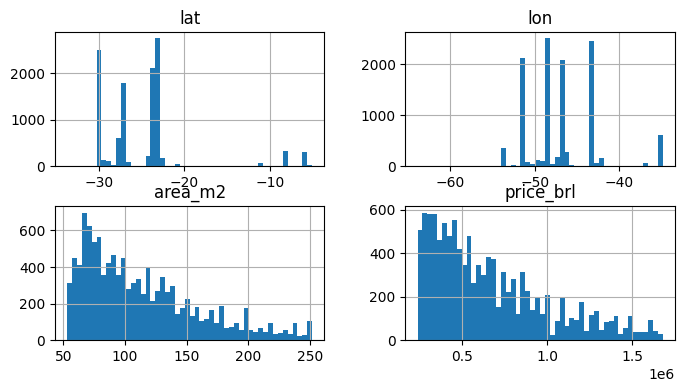

In [12]:
df.hist(bins=50, figsize=(8,4))

- **Area_m2**: The majority of properties are smaller than 100 m².
- **Price_brl**: Most properties are priced below R$500,000.


# 4 - Analyse
---

## 4.1 Map Lat and Lon distribution

/tmp/ipykernel_17/1096556445.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


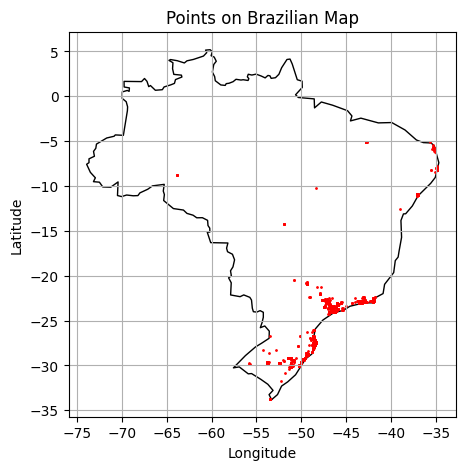

In [13]:
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = brazil[brazil['name'] == 'Brazil']

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

plt.figure(figsize=(5, 5))

brazil.plot(ax=plt.gca(), color='white', edgecolor='black')

geo_df.plot(ax=plt.gca(), marker='o', color='red', markersize=1)

plt.title('Points on Brazilian Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

- **Lat and Lon Plot**: 
  - Most properties are concentrated in the **Southeast** and **South** regions of Brazil.


## 4.2 Analyse per property type

In [14]:
df_property_type_count = df['property_type'].value_counts().reset_index()

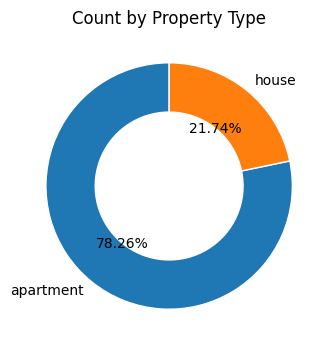

In [15]:
plt.figure(figsize=(4, 4))

plt.pie(df_property_type_count['count'], 
        labels=df_property_type_count['property_type'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Property Type')

plt.show()

  - Apartments: 78.26%
  - Houses: 21.74%


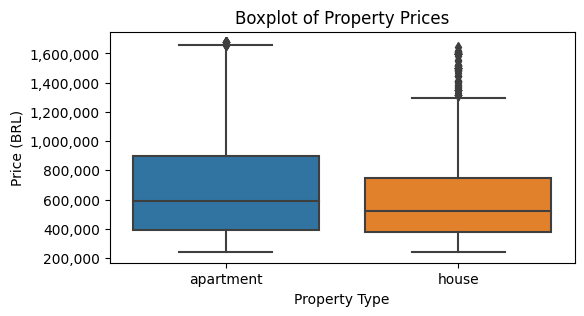

In [16]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='property_type', y='price_brl')

plt.title('Boxplot of Property Prices')
plt.xlabel('Property Type')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

- **Houses**:
    -  Mean price is **R$ 598,133.40**
      
    -  Maximum price of **R$ 1,646,911**
 
- **Apartments**:
    -  Mean price is **R$ 683,442.60**
      
    -  Maximum price of **R$ 1,676,854**.
.
.
.
**.



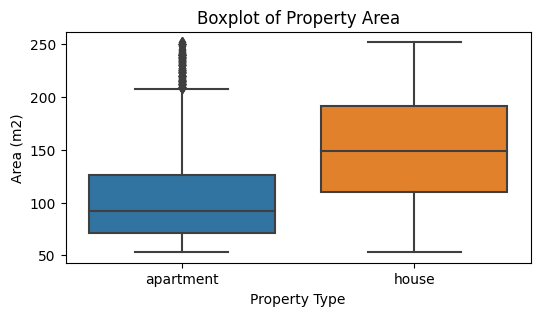

In [17]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='property_type', y='area_m2')

plt.title('Boxplot of Property Area')
plt.xlabel('Property Type')
plt.ylabel('Area (m2)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

  - **Apartments**: Mean area is **102.78 m²**, with a maximum of **252 m²**.
  - **Houses**: Mean area is **151.21 m²**, with a maximum of **252 m²**.


## 4.3 Analyse per property type and regions

### Apartament

In [18]:
df_ap = df[df['property_type'] == "apartment"]

In [19]:
df_ap.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,lat,lon,area_m2,price_brl
count,8838.000000,8838.000000,8838.000000,8.838000e+03
mean,-24.621156,-46.694933,102.777438,6.834426e+05
std,5.587298,4.338600,39.795735,3.584911e+05
min,-33.692432,-63.905184,53.000000,2.395506e+05
1%,-30.104843,-53.811765,54.000000,2.459422e+05
25%,-27.748068,-48.729183,71.000000,3.927652e+05
50%,-23.959765,-46.751954,92.000000,5.888953e+05
75%,-22.965425,-43.352279,126.000000,8.983149e+05
99%,-5.794719,-34.898106,230.000000,1.597004e+06
max,-5.044685,-34.841721,252.000000,1.676854e+06


In [20]:
df_ap_region_count = df_ap['region'].value_counts().reset_index()

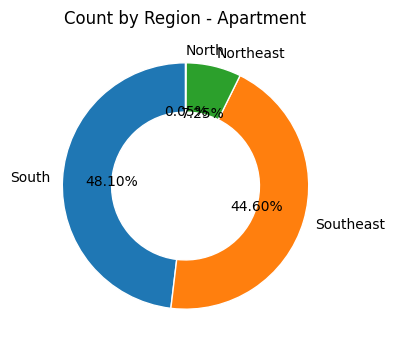

In [21]:
plt.figure(figsize=(4, 4))

plt.pie(df_ap_region_count['count'], 
        labels=df_ap_region_count['region'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Region - Apartment')

plt.show()

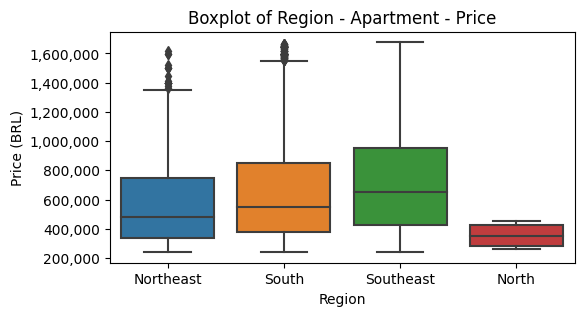

In [22]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ap, x='region', y='price_brl')

plt.title('Boxplot of Region - Apartment - Price')
plt.xlabel('Region')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

  - **North**: Fewer data points and lower property prices.
  - **Northeast**: The lowest mean price.
  - **South** and **Southeast**: The most expensive regions.


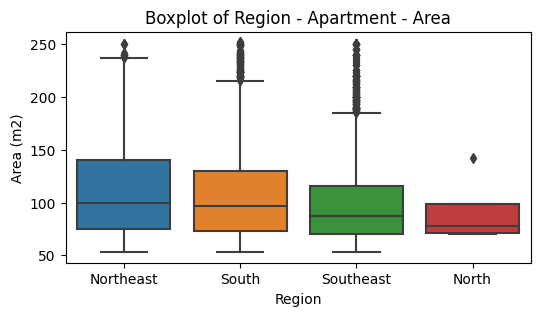

In [23]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ap, x='region', y='area_m2')

plt.title('Boxplot of Region - Apartment - Area')
plt.xlabel('Region')
plt.ylabel('Area (m2)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

  - Outliers are present across all regions, with the **Southeast** region showing the most.

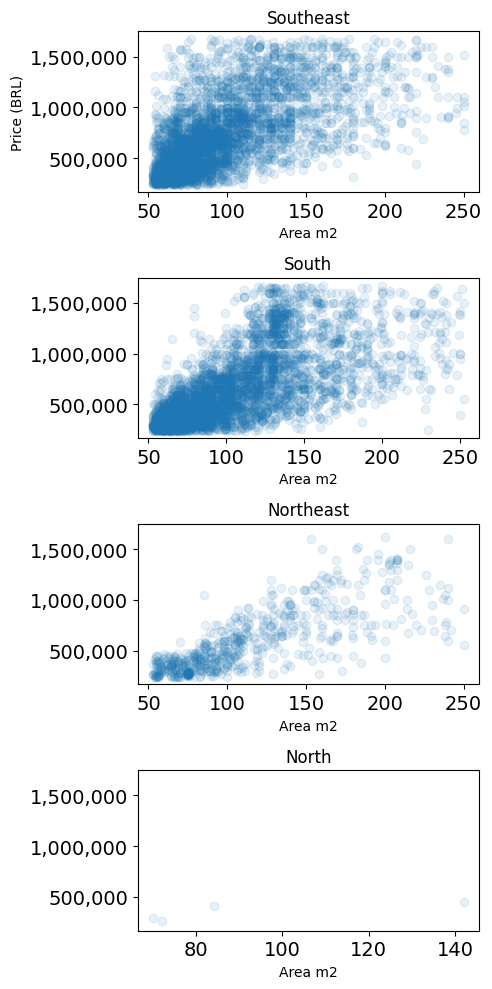

In [24]:
regions = ['Southeast', 'South', 'Northeast', 'North']

fig, axes = plt.subplots(4, 1, figsize=(5, 10), sharey=True)

for ax, region in zip(axes, regions):
    df_region = df_ap[df_ap['region'] == region]
    
    ax.scatter(df_region['area_m2'], df_region['price_brl'], alpha=0.1)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel("Area m2")
    ax.set_title(region)
    
    if ax == axes[0]:
        ax.set_ylabel("Price (BRL)")
    
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

In [25]:
pearsonr(df_ap['price_brl'], df_ap['area_m2'])

PearsonRResult(statistic=0.6213944339153771, pvalue=0.0)

- There is a positive correlation of **62.14%** between **Price_brl** and **Area_m2** for apartments, indicating that as property size increases, so does the price.

### House

In [26]:
df_ho = df[df['property_type'] == "house"]

In [27]:
df_ho.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,lat,lon,area_m2,price_brl
count,2455.000000,2455.000000,2455.000000,2.455000e+03
mean,-25.027838,-47.026046,151.213035,5.981334e+05
std,4.370587,3.674939,52.179083,2.912287e+05
min,-31.758280,-63.898059,53.000000,2.395506e+05
1%,-30.163090,-53.814715,61.000000,2.495319e+05
25%,-28.132981,-49.387934,110.000000,3.792885e+05
50%,-23.619699,-46.927982,149.000000,5.240170e+05
75%,-22.935587,-43.401979,192.000000,7.485957e+05
99%,-5.866949,-35.205231,250.000000,1.518329e+06
max,-5.051253,-34.851379,252.000000,1.646911e+06


In [28]:
df_ho_region_count = df_ho['region'].value_counts().reset_index()

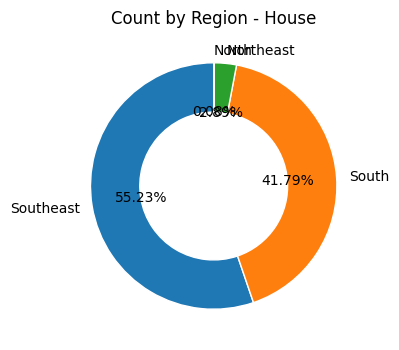

In [29]:
plt.figure(figsize=(4, 4))

plt.pie(df_ho_region_count['count'], 
        labels=df_ho_region_count['region'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Region - House')

plt.show()

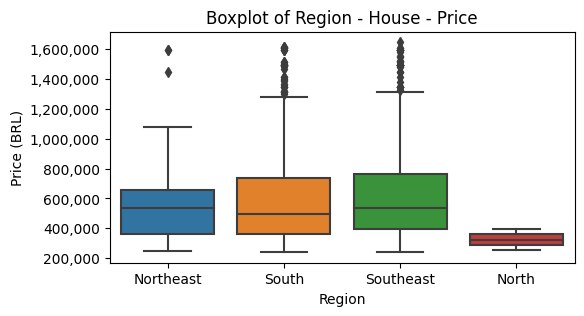

In [30]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ho, x='region', y='price_brl')

plt.title('Boxplot of Region - House - Price')
plt.xlabel('Region')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

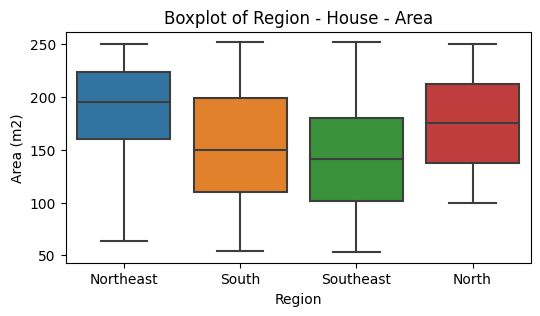

In [31]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ho, x='region', y='area_m2')

plt.title('Boxplot of Region - House - Area')
plt.xlabel('Region')
plt.ylabel('Area (m2)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

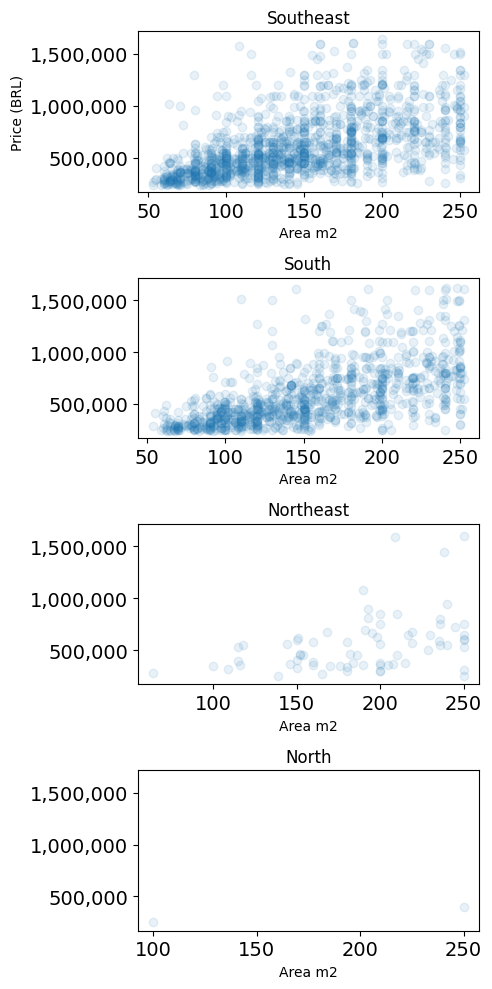

In [32]:
regions = ['Southeast', 'South', 'Northeast', 'North']

fig, axes = plt.subplots(4, 1, figsize=(5, 10), sharey=True)

for ax, region in zip(axes, regions):
    df_region = df_ho[df_ho['region'] == region]
    
    ax.scatter(df_region['area_m2'], df_region['price_brl'], alpha=0.1)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel("Area m2")
    ax.set_title(region)
    
    if ax == axes[0]:
        ax.set_ylabel("Price (BRL)")
    
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

In [33]:
pearsonr(df_ho['price_brl'], df_ho['area_m2'])

PearsonRResult(statistic=0.5548965569672083, pvalue=2.6405238002701964e-198)

# 5 - Estimate Price_brl
---

To estimate **Price_brl**, the features **Area_m2** and **Property_type** were selected. Categorical features like **Property_type** were encoded. For location, the features **Lat**, **Lon**, **Region**, and **State** were considered, but only **Lat** and **Lon** were used due to the high concentration of data in a few regions.

## 5.1 Encode categorical variables

In [34]:
data = {
    'property_type': ['apartment', 'house'],
}

encoder = OneHotEncoder(handle_unknown='ignore')

encoded_data = encoder.fit_transform(df[['property_type']])

cat_variable_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['property_type']))

display(cat_variable_encoded)

,property_type_apartment,property_type_house
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
11288,0.0,1.0
11289,0.0,1.0
11290,1.0,0.0
11291,1.0,0.0


In [35]:
df_encoded = pd.concat([df[['price_brl', 'area_m2', 'lat', 'lon']].copy(),
                        cat_variable_encoded], axis=1)

display(df_encoded)

,price_brl,area_m2,lat,lon,property_type_apartment,property_type_house
0,414222.98,72.0,-8.134204,-34.906326,1.0,0.0
1,848408.53,136.0,-8.126664,-34.903924,1.0,0.0
2,299438.28,75.0,-8.125550,-34.907601,1.0,0.0
3,848408.53,187.0,-8.120249,-34.895920,1.0,0.0
4,464129.36,80.0,-8.142666,-34.906906,1.0,0.0
...,...,...,...,...,...,...
11288,419213.60,180.0,-23.595098,-46.796448,0.0,1.0
11289,429194.89,250.0,-23.587495,-46.559401,0.0,1.0
11290,252398.80,55.0,-23.522029,-46.189290,1.0,0.0
11291,319400.84,57.0,-23.526443,-46.529182,1.0,0.0


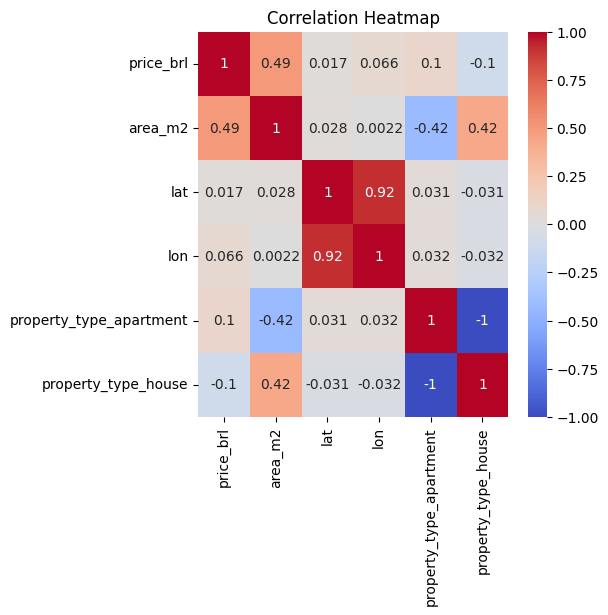

In [36]:
correlation_matrix = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(5, 5))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add titles and labels
plt.title("Correlation Heatmap")
plt.show()


In [37]:
X = pd.DataFrame({'area_m2': df_encoded['area_m2'],
                  'lat': df_encoded['lat'],
                  'lon': df_encoded['lon'],
                  'property_type_apartment': df_encoded['property_type_apartment'],
                  'property_type_house': df_encoded['property_type_house']})
display(X)

y = df_encoded['price_brl']
display(y)

,area_m2,lat,lon,property_type_apartment,property_type_house
0,72.0,-8.134204,-34.906326,1.0,0.0
1,136.0,-8.126664,-34.903924,1.0,0.0
2,75.0,-8.125550,-34.907601,1.0,0.0
3,187.0,-8.120249,-34.895920,1.0,0.0
4,80.0,-8.142666,-34.906906,1.0,0.0
...,...,...,...,...,...
11288,180.0,-23.595098,-46.796448,0.0,1.0
11289,250.0,-23.587495,-46.559401,0.0,1.0
11290,55.0,-23.522029,-46.189290,1.0,0.0
11291,57.0,-23.526443,-46.529182,1.0,0.0


0        414222.98
1        848408.53
2        299438.28
3        848408.53
4        464129.36
           ...    
11288    419213.60
11289    429194.89
11290    252398.80
11291    319400.84
11292    289457.01
Name: price_brl, Length: 11293, dtype: float64

## 5.2 Linear Regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
def train_test_result(model, X_train, y_train, X_test, y_test):
    
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    print(f'Train \n MSE: {mse_train} \n R2: {r2_train}')

    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'Test \n MSE: {mse_test} \n R2: {r2_test}')

Linear Regression is a basic statistical method used to predict the relationship between one dependent variable and one or more independent variables. It fits a straight line through the data points to find the best match, showing how the variables are related. The formula is usually \(y = mx + b\), where \(y\) is the outcome, \(x\) is the input variable, \(m\) is the slope, and \(b\) is the intercept. The goal is to minimize the difference between the predicted and actual values. Linear Regression is simple, easy to interpret, and works well when the relationship between variables is roughly straight or linear.


In [40]:
model_Reg = LinearRegression()
model_Reg.fit(X_train, y_train)

train_test_result(model_Reg, X_train, y_train, X_test, y_test)

Train 
 MSE: 72896765964.66656 
 R2: 0.3931928578470043
Test 
 MSE: 77714551679.85623 
 R2: 0.3557408572265951


### **Linear Regression**:
- **Training Set**:
  - **MSE**: 72,896,765,964.67
  - **R²**: 0.3932
- **Test Set**:
  - **MSE**: 77,714,551,679.86
  - **R²**: 0.3557


Linear regression provided modest results, with relatively low R² values indicating that it does not explain much of the variance in the data.

Grid Search Cross-Validation (Grid Search CV) is a method used in machine learning to optimize a model’s hyperparameters by systematically testing different combinations. It creates a grid of possible hyperparameter values and evaluates the model for each combination using cross-validation, where the data is split into multiple folds to ensure that the model performs well on unseen data.

In [41]:
def grid_search_cv(model, parameters_grid):
    
    search = GridSearchCV(
        estimator=model,
        param_grid=parameters_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=2
        )

    search.fit(X_train, y_train)
    
    print("Melhores parâmetros encontrados:", search.best_params_)
    print("Melhor score:", search.best_score_)
    
    best_model = search.best_estimator_

    return best_model

## 5.3 Random Forest Regressor

Random Forest is an ensemble learning method used for classification and regression tasks that builds multiple decision trees during training and combines their results to improve accuracy and reduce overfitting. Each tree is trained on a random subset of the data and features, making the model robust and less sensitive to individual data points or noise. By averaging the outcomes (for regression) or taking the majority vote (for classification) across all trees, Random Forest achieves higher predictive power and generalization than a single decision tree, making it a popular choice for handling large datasets with complex interactions between variables.

In [42]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model_best = grid_search_cv(RandomForestRegressor(), param_grid_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.0s
[CV] END max_depth=10, min_sample

In [43]:
rf_model_best.fit(X_train, y_train)

train_test_result(rf_model_best, X_train, y_train, X_test, y_test)

Train 
 MSE: 18215470640.083996 
 R2: 0.8483708085563254
Test 
 MSE: 40193881286.34797 
 R2: 0.6667898747077163


### 2. **Random Forest Regressor** (with Grid Search CV):
- **Parameters tuned**: 
  - `'n_estimators': [50, 100, 200]`
  - `'max_depth': [10, 20, 30]`
  - `'min_samples_split': [2, 5, 10]`
  - `'min_samples_leaf': [1, 2, 4]`
  
- **Best model parameters**: 
  - `max_depth=30`, 
  - `min_samples_leaf=2`, 
  - `min_samples_split=10`, 
  - `n_estimators=200`
  
- **Training Set**:
  - **MSE**: 18,110,755,754.76
  - **R²**: 0.8492
- **Test Set**:
  - **MSE**: 40,181,566,616.65
  - **R²**: 0.6669


The random forest model performed significantly better, with lower MSE and higher R² values in both the training and test sets.

# 6 - Conclusion
---


- **Random Forest** outperformed **Linear Regression** for predicting property prices, with an R² of **0.6669** on the test set.
- The features **Area_m2** and **Property_type** were strong predictors, while geographical coordinates (Lat and Lon) added further explanatory power.
- Further refinement and tuning of the models, along with the addition of more features, could improve the predictive performance. However, the **Random Forest** model currently stands as the best-performing option.
